# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
transforms = transforms.ToTensor()

# Create training set and define training dataloader
train_data = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transforms)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms)
test_loader = DataLoader(test_data, batch_size=100)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**To convert an image data set into a tensor.**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

In [4]:
print("Number of MNIST train data examples: {}".format(len(train_data)))
print("Number of MNIST test data examples: {}".format(len(test_data)))

Number of MNIST train data examples: 60000
Number of MNIST test data examples: 10000


In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print("number of images: {}".format(images.shape))
print("number of labels: {}".format(labels.shape))

number of images: torch.Size([100, 1, 28, 28])
number of labels: torch.Size([100])


4


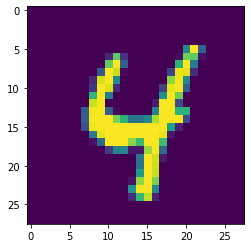

3


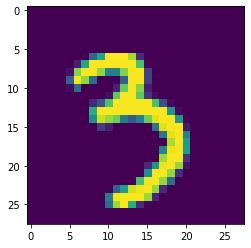

9


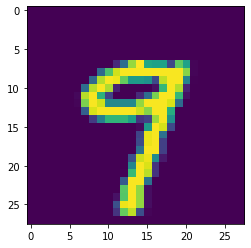

2


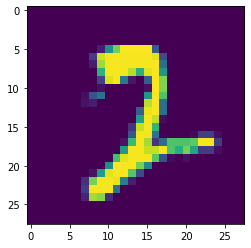

2


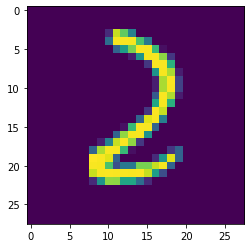

In [6]:
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28 * 28, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x
    
net = Net()

In [8]:
# Choose an optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Choose a loss function
criterion = nn.CrossEntropyLoss()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
num_epochs = 10

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Zero out the gradients of the optimizer
        optimizer.zero_grad()

        # Get the outputs of your model and compute your loss
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # Compute the loss gradient using the backward method and have the optimizer take a step
        loss.backward()
        optimizer.step()

        # Compute the accuracy and print the accuracy and loss
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))

    # The validation step is done for you.
    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 88.65% training loss: 0.40533
Epoch 1 validation accuracy: 94.04% validation loss: 0.20568
Epoch 2 training accuracy: 95.03% training loss: 0.17215
Epoch 2 validation accuracy: 95.85% validation loss: 0.13878
Epoch 3 training accuracy: 96.50% training loss: 0.11852
Epoch 3 validation accuracy: 96.27% validation loss: 0.12194
Epoch 4 training accuracy: 97.33% training loss: 0.09010
Epoch 4 validation accuracy: 97.31% validation loss: 0.09009
Epoch 5 training accuracy: 97.81% training loss: 0.07003
Epoch 5 validation accuracy: 97.36% validation loss: 0.08831
Epoch 6 training accuracy: 98.20% training loss: 0.05765
Epoch 6 validation accuracy: 97.33% validation loss: 0.08217
Epoch 7 training accuracy: 98.58% training loss: 0.04653
Epoch 7 validation accuracy: 97.69% validation loss: 0.07649
Epoch 8 training accuracy: 98.86% training loss: 0.03805
Epoch 8 validation accuracy: 97.79% validation loss: 0.07855
Epoch 9 training accuracy: 99.05% training loss: 0.03131

Plot the training loss (and validation loss/accuracy, if recorded).

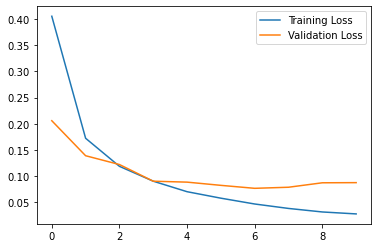

In [10]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
def test():
    net.eval()
    test_loss = 0
    test_correct = 0
    for i, data in enumerate(test_loader):
        inputs, labels  = data
        
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
            
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs.data, 1)
        test_correct += (preds == labels).sum().item()
        test_loss += loss.item()
    print(f'Epoch {epoch + 1} test accuracy: {test_correct/len(test_loader):.2f}% test loss: {test_loss/len(test_loader):.5f}')

In [12]:
for epoch in range(num_epochs):
    test()

Epoch 1 test accuracy: 97.35% test loss: 0.09045
Epoch 2 test accuracy: 98.56% test loss: 0.04487
Epoch 3 test accuracy: 99.46% test loss: 0.02357
Epoch 4 test accuracy: 99.73% test loss: 0.01321
Epoch 5 test accuracy: 99.91% test loss: 0.00793
Epoch 6 test accuracy: 99.99% test loss: 0.00513
Epoch 7 test accuracy: 99.99% test loss: 0.00383
Epoch 8 test accuracy: 100.00% test loss: 0.00297
Epoch 9 test accuracy: 100.00% test loss: 0.00244
Epoch 10 test accuracy: 100.00% test loss: 0.00204


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [14]:
# Add dropout = 0.2

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28 * 28, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 10)
        
        self.dropout=nn.Dropout(0.2)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x
    
net2 = Net2()

In [15]:
# Choose an optimizer
optimizer = optim.Adam(net2.parameters(), lr=0.001)

# Choose a loss function
criterion = nn.CrossEntropyLoss()

In [17]:
num_epochs = 10

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net2.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Zero out the gradients of the optimizer
        optimizer.zero_grad()

        # Get the outputs of your model and compute your loss
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        
        # Compute the loss gradient using the backward method and have the optimizer take a step
        loss.backward()
        optimizer.step()

        # Compute the accuracy and print the accuracy and loss
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))

    # The validation step is done for you.
    val_loss = 0.0
    val_correct = 0
    net2.eval()
    for inputs, labels in test_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = net2(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 98.38% training loss: 0.05290
Epoch 1 validation accuracy: 97.53% validation loss: 0.07976
Epoch 2 training accuracy: 98.66% training loss: 0.04279
Epoch 2 validation accuracy: 97.66% validation loss: 0.07866
Epoch 3 training accuracy: 98.89% training loss: 0.03537
Epoch 3 validation accuracy: 97.69% validation loss: 0.07531
Epoch 4 training accuracy: 99.10% training loss: 0.03019
Epoch 4 validation accuracy: 97.63% validation loss: 0.08346
Epoch 5 training accuracy: 99.19% training loss: 0.02574
Epoch 5 validation accuracy: 97.72% validation loss: 0.07180
Epoch 6 training accuracy: 99.31% training loss: 0.02137
Epoch 6 validation accuracy: 97.60% validation loss: 0.08262
Epoch 7 training accuracy: 99.44% training loss: 0.01798
Epoch 7 validation accuracy: 97.52% validation loss: 0.08713
Epoch 8 training accuracy: 99.53% training loss: 0.01474
Epoch 8 validation accuracy: 97.42% validation loss: 0.09544
Epoch 9 training accuracy: 99.54% training loss: 0.01373

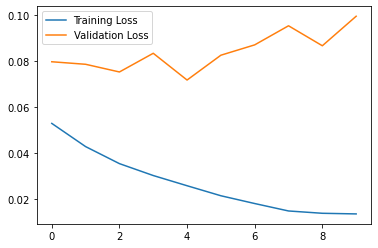

In [18]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

In [19]:
def test2():
    net2.eval()
    test_loss = 0
    test_correct = 0
    for i, data in enumerate(test_loader):
        inputs, labels  = data
        
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
            
        optimizer.zero_grad()
        
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs.data, 1)
        test_correct += (preds == labels).sum().item()
        test_loss += loss.item()
    print(f'Epoch {epoch + 1} test accuracy: {test_correct/len(test_loader):.2f}% test loss: {test_loss/len(test_loader):.5f}')

In [20]:
for epoch in range(num_epochs):
    test2()

Epoch 1 test accuracy: 97.09% test loss: 0.10766
Epoch 2 test accuracy: 98.63% test loss: 0.04064
Epoch 3 test accuracy: 99.65% test loss: 0.01528
Epoch 4 test accuracy: 99.85% test loss: 0.00738
Epoch 5 test accuracy: 99.96% test loss: 0.00415
Epoch 6 test accuracy: 100.00% test loss: 0.00252
Epoch 7 test accuracy: 100.00% test loss: 0.00171
Epoch 8 test accuracy: 100.00% test loss: 0.00133
Epoch 9 test accuracy: 100.00% test loss: 0.00110
Epoch 10 test accuracy: 100.00% test loss: 0.00093


## Saving your model
Using `torch.save`, save your model for future loading.

In [21]:
torch.save(Net, "Net.pth")
torch.save(Net2, "Net2.pth")